# Chapter 4 Balance and Sequentiality in Bayesian Analyses

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pyreadr
import requests
import seaborn as sns

from scipy import integrate, stats

In [2]:
%config InlineBackend.figure_format = 'retina'
%load_ext watermark
RANDOM_SEED = 1301
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

## 4.1 Different priors, different posteriors

In [3]:
fake_news_url = r"https://github.com/bayes-rules/bayesrules/blob/master/data/bechdel.rda?raw=true"
r = requests.get(fake_news_url, allow_redirects=True)
open("fake_news.rda", "wb").write(r.content)
try:
    result = pyreadr.read_r("fake_news.rda")
except FileNotFoundError:
    print("Could not read R data file fake_news.rda")

In [4]:
df = result["bechdel"]

In [5]:
bechdel_20 = df.sample(n=20)

In [6]:
bechdel_20

,year,title,binary
1753,1977.0,A Bridge Too Far,FAIL
679,2007.0,Diary of the Dead,PASS
848,2005.0,Domino,PASS
665,2007.0,28 Weeks Later,PASS
251,2011.0,No Strings Attached,PASS
1110,2002.0,Panic Room,PASS
941,2004.0,Collateral,FAIL
192,2011.0,Arthur Christmas,FAIL
1584,1992.0,The Muppet Christmas Carol,FAIL
236,2011.0,Killer Elite,FAIL


In [7]:
pd.concat(
    [
        bechdel_20["binary"].value_counts().rename("n"),
        bechdel_20["binary"].value_counts(normalize=True).rename("percent"),
    ],
    axis=1,
)

,n,percent
PASS,12,0.6
FAIL,8,0.4


## 4.2 Different data, different posteriors

In [8]:
bechdel_91 = df[df["year"] == 1991]

pd.concat(
    [
        bechdel_91["binary"].value_counts().rename("n"),
        bechdel_91["binary"].value_counts(normalize=True).rename("percent"),
    ],
    axis=1,
)

,n,percent
FAIL,7,0.538462
PASS,6,0.461538


In [9]:
bechdel_2000 = df[df["year"] == 2000]

pd.concat(
    [
        bechdel_2000["binary"].value_counts().rename("n"),
        bechdel_2000["binary"].value_counts(normalize=True).rename("percent"),
    ],
    axis=1,
)

,n,percent
FAIL,34,0.539683
PASS,29,0.460317


In [10]:
bechdel_2013 = df[df["year"] == 2013]

pd.concat(
    [
        bechdel_2013["binary"].value_counts().rename("n"),
        bechdel_2013["binary"].value_counts(normalize=True).rename("percent"),
    ],
    axis=1,
)

,n,percent
FAIL,53,0.535354
PASS,46,0.464646


## 4.3 Striking a balance between the prior & data

### 4.3.1 Connecting observations to concepts

In [11]:
def plot_beta_binomial(
    alpha, beta, y=None, n=None, prior=True, likelihood=True, posterior=True
) -> None:
    """Plot a Beta-Binomial Bayesian Model

    @param alpha,beta positive shape parameters of the prior Beta model
    @param y observed number of successes
    @param n observed number of trials
    @param prior a logical value indicating whether the prior model should be plotted
    @param likelihood a logical value indicating whether the scaled likelihood should be plotted
    @param posterior a logical value indicating whether posterior model should be plotted
    """

    if y is None or n is None:
        print("Warning: to visualize the posterior specify function parameters y and n")

    θ = np.linspace(0, 1, 100)
    p_theta_given_y = stats.beta.pdf(θ, alpha, beta)
    plt.fill_between(θ, p_theta_given_y, lw=4, color="k", label="prior", alpha=0.2)
    alpha_post = alpha + y
    beta_post = beta + n - y
    p_theta_given_y_post = stats.beta.pdf(θ, alpha_post, beta_post)
    plt.fill_between(θ, p_theta_given_y_post, lw=4, color="r", label="posterior", alpha=0.2)
    likelihood = stats.binom.pmf(y, n, θ)
    scale_factor = integrate.simpson(likelihood, θ)
    plt.fill_between(
        θ, likelihood / scale_factor, lw=4, color="b", label="likelihood scaled", alpha=0.2
    )
    plt.xlabel(r"$\pi$")
    plt.ylabel("density")
    plt.legend()


def summarize_beta_binomial(alpha, beta, y=None, n=None):
    """Summarize a Beta-Binomial Bayesian model

    @param alpha,beta positive shape parameters of the prior Beta model
    @param y number of successes
    @param n number of trials

    Return: Pandas dataframe summarizing beta binomial
    """

    def beta_mean(a, b):
        return a / (a + b)

    def beta_mode(a, b):
        if a < 1 and b < 1:
            return "0 and 1"
        elif a <= 1 and b > 1:
            return 0
        elif a > 1 and b < 1:
            return 1
        else:
            return (a - 1) / (a + b - 2)

    def beta_var(a, b):
        return a * b / ((a + b) ** 2 * (a + b + 1))

    prior_mean = beta_mean(alpha, beta)
    prior_mode = beta_mode(alpha, beta)
    prior_var = beta_var(alpha, beta)
    prior_sd = np.sqrt(prior_var)
    if y is None and n is None:
        summary = pd.DataFrame(
            {
                "alpha": alpha,
                "beta": beta,
                "mean": prior_mean,
                "mode": prior_mode,
                "var": prior_var,
                "sd": prior_sd,
            },
            index=["prior"],
        )
    else:
        post_alpha = y + alpha
        post_beta = n - y + beta
        post_mean = beta_mean(post_alpha, post_beta)
        post_mode = beta_mode(post_alpha, post_beta)
        post_var = beta_var(post_alpha, post_beta)
        post_sd = np.sqrt(post_var)
        summary = pd.DataFrame(
            {
                "alpha": [alpha, post_alpha],
                "beta": [beta, post_beta],
                "mean": [prior_mean, post_mean],
                "mode": [prior_mode, post_mode],
                "var": [prior_var, post_var],
                "sd": [prior_sd, post_sd],
            },
            index=["prior", "posterior"],
        )
    return summary

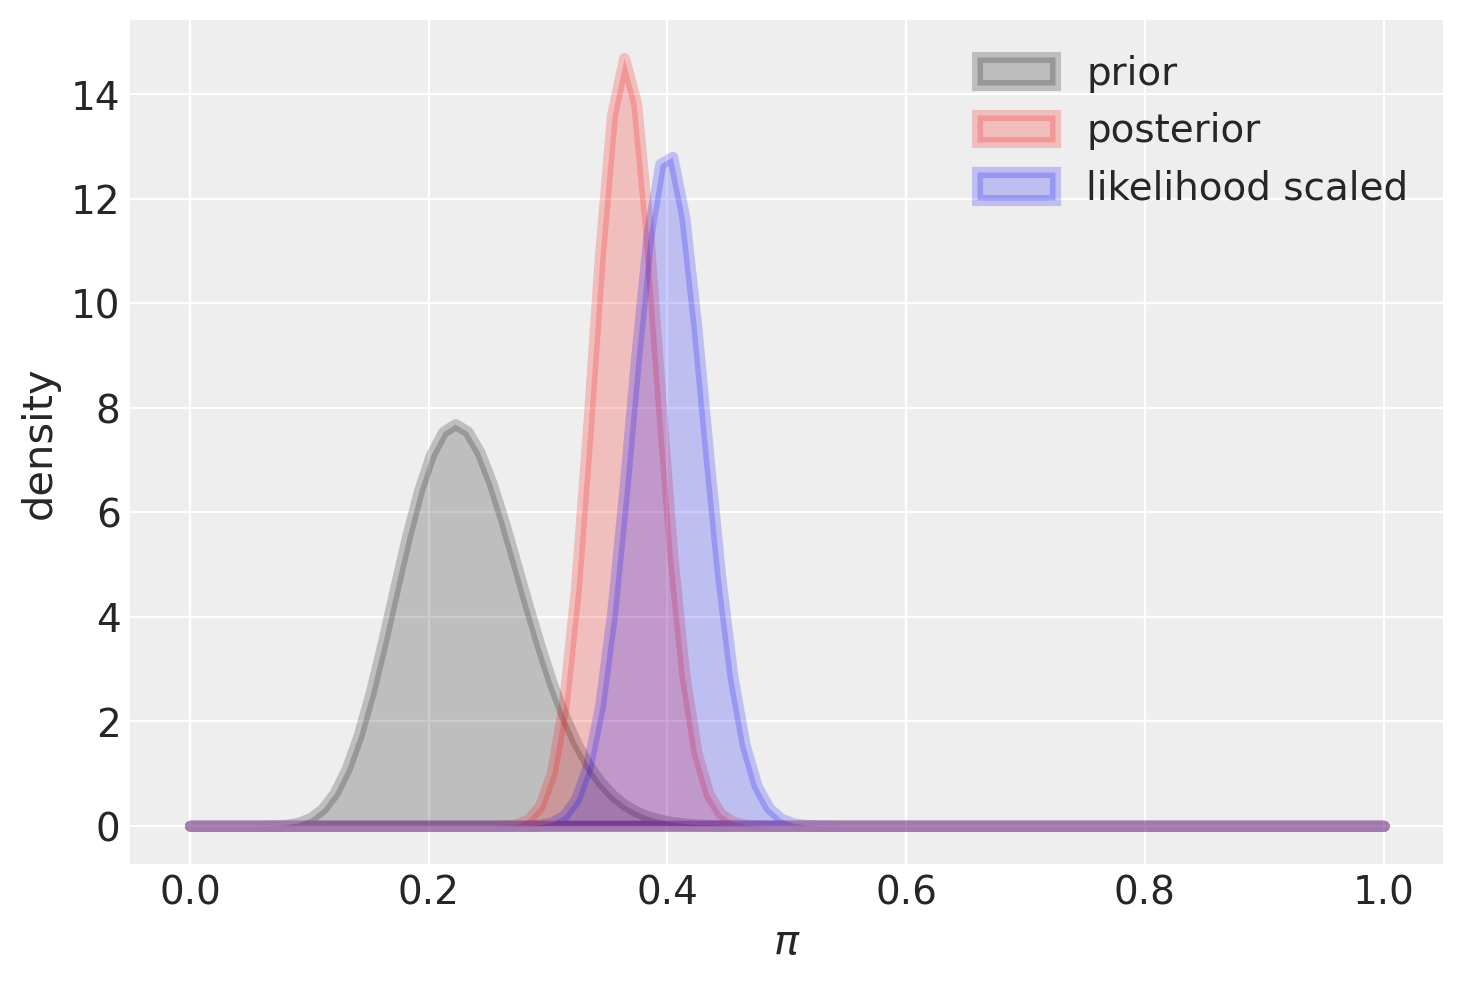

In [12]:
# Plot the Beta-Binomial model
plot_beta_binomial(alpha=15, beta=50, y=100, n=250)

In [13]:
summarize_beta_binomial(alpha=15, beta=50, y=100, n=250)

,alpha,beta,mean,mode,var,sd
prior,15,50,0.230769,0.222222,0.002690,0.051862
posterior,115,200,0.365079,0.364217,0.000734,0.027084


In [14]:
watermark

Last updated: 2022-06-24T15:55:43.930593+02:00

Python implementation: CPython
Python version       : 3.10.4
IPython version      : 8.1.1

Compiler    : Clang 12.0.1 
OS          : Darwin
Release     : 18.7.0
Machine     : x86_64
Processor   : i386
CPU cores   : 8
Architecture: 64bit

